# Using initial depletion calculations, we can relate depletion to pumping rates to calculate Depletion Potential for each well. We will also look at this information spatially

In [1]:
import yaml
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import os, platform
import geopandas as gpd
from shapely.geometry import Point

In [2]:
#### PyCap Run Name is what all your outputs will have as a name. 
pycap_run_name = "LPR_Redux"

#### Base directory for runs
parent_run_path = Path("../pycap_runs")

#### We will save the results in the same directory as the base run
base_run_path = parent_run_path / "pycap_base"

### First we will need all the information from the model input (for locations and Q data)

In [3]:
with open(base_run_path / "LPR_redux.yml", "r") as ifp:
    indat = yaml.safe_load(ifp)

## Now it would be conventient to make a GeoDataFrame of the input

### quick note - streamflow is in CFS but Q is reported in GPM, so to calculate ratios, we need to convert (beware smashing [Mars Rovers](https://en.wikipedia.org/wiki/Mars_Climate_Orbiter)!) and the conversion from GPM to CFS is:
$1 CFS = 1 GPM=\frac{G}{M}\times\frac{1ft^3}{7.48052G}\times\frac{1M}{60S}$  
$1 CFS = 0.002228 \times 1 GPM$

In [4]:
GPM2CFS = 1/7.48052/60

In [5]:
indcol = [i for i in indat.keys() if 'well' in i.lower()]
names = [indat[i]['name'] for i in indcol]
locs = [Point(-indat[i]['loc']['x'],indat[i]['loc']['y']) for i in indcol]
Q = [indat[i]['Q'] for i in indcol]

wells_gdf = gpd.GeoDataFrame(index = indcol, data={"name":names, 
                                                   "Q_gpm":Q, 
                                                   "Q_cfs": [Qi*GPM2CFS for Qi in Q],
                                                   "geometry":locs}, crs=4326)

In [6]:
wells_gdf.explore()

### Load in the results file

In [7]:
depl = pd.read_csv(
    base_run_path / f"output/{pycap_run_name}.table_report.base_stream_depletion.csv", index_col = 0
)
depl

,LPR
418,6.689931e-03
466,3.830911e-01
467,2.874797e-01
490,5.003177e-12
509,2.753485e-07
...,...
94988,2.480979e-08
95068,7.244530e-06
total_proposed,6.689931e-03
total_existing,4.679641e+00


### Now join this into the wells GeoDataFrame

In [8]:
wells_gdf = wells_gdf.merge(depl.LPR, 
                left_on = "name", 
                right_index=True).rename(columns={"LPR":"DEPL_cfs"})

In [9]:
wells_gdf["Depletion_Potential"] = wells_gdf["DEPL_cfs"]/wells_gdf["Q_cfs"]

In [10]:
wells_gdf.explore(column="Depletion_Potential",
                  vmin=0,vmax=1,
                  style_kwds={"style_function":
                                  lambda x: 
                                  {"radius":x["properties"]["Depletion_Potential"]*15}})


<Axes: >

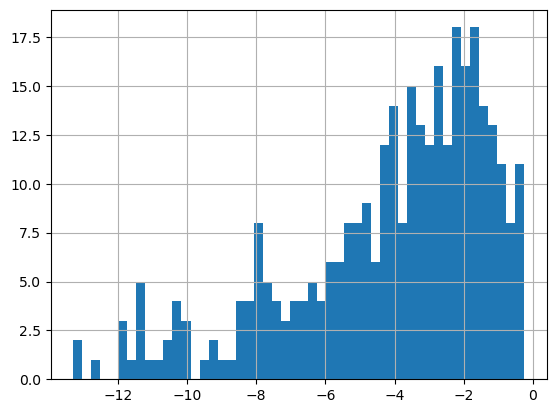

In [11]:
wells_gdf.Depletion_Potential.apply(np.log10).hist(bins=50)

### Now how can we use this information? One idea is to explore a threshold of depletion potential for optimization - we could use a subset of wells to manage only if their depletion potential _relative to the specific response on the Little Plover River_ is at or above the threshold. This has many implications to consider....

In [17]:
dp_thresh=.001

In [18]:
mmap = wells_gdf.explore(color='red',
                         style_kwds={'opacity':.5,
                                     'weight': 1})
wells_gdf.loc[wells_gdf.Depletion_Potential>=dp_thresh].explore(m=mmap,column="Depletion_Potential",
                  vmin=0,vmax=1,
                  style_kwds={"style_function":
                                  lambda x: 
                                  {"radius":x["properties"]["Depletion_Potential"]*15}})

### Let's just save the entire set of depletion potential results for future consideration

In [14]:
# we can save down the list of wells with dp greater than the threshold for future consideration
wells_gdf.to_file(base_run_path / 'depletion_potential.json', driver='GeoJSON')